In [1]:
%cd ../..

/cis/home/zfang23/code/LearnedRegularizers


# Note
The lpn_no_patch network's definition is not compatible with prior evaluation code. Inversion does not work.

In [2]:
import argparse
import datetime
import logging
import os
import time
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch
from deepinv.loss.metric import PSNR
from deepinv.optim.optimizers import optim_builder
from deepinv.optim.prior import PnP
from deepinv.utils.plotting import plot
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm

import sys

sys.path.append("../..")

from operators import get_evaluation_setting
from priors.lpn.lpn_no_patch import LPNPrior
from priors.lpn.prior import evaluate_prior
from priors.lpn.invert_model import invert


device = "cuda"

print("device: ", device)
torch.random.manual_seed(0)  # make results deterministic

pretrained_path = "weights/lpn_no_patch_64_bsd_noise_0.1/LPN.pt"

device:  cuda


/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
problem = "Denoising"
dataset, physics, data_fidelity = get_evaluation_setting(problem, device)

In [4]:
regularizer = LPNPrior(pretrained=pretrained_path).to(device)
regularizer.eval()

init weights


LPNPrior(
  (lpn): LPN(
    (lin): ModuleList(
      (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1-5): 5 x Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (6): Conv2d(256, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (7): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    )
    (res): ModuleList(
      (0-4): 5 x Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    )
    (pool): ModuleList(
      (0-2): 3 x AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (act): Softplus(beta=100.0, threshold=20.0)
  )
)

torch.Size([1, 1, 481, 321]) tensor(0., device='cuda:0') tensor(0.9999, device='cuda:0')


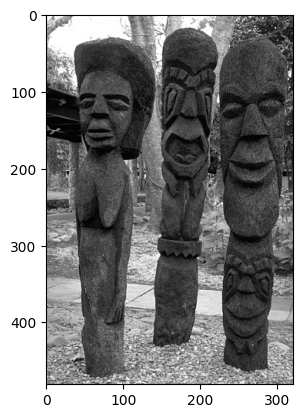

In [5]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
for i, x in enumerate(dataloader):
    if i == 0:
        break
x = x.to(device)
plt.figure()
plt.imshow(x[0, 0].cpu(), cmap="gray", vmin=0, vmax=1)
print(x.shape, x.min(), x.max())

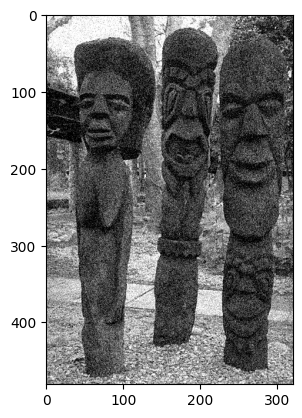

In [6]:
noisy = x + 0.1 * torch.randn_like(x)
plt.figure()
plt.imshow(noisy[0, 0].cpu(), cmap="gray", vmin=0, vmax=1)

In [7]:
compute_prior = lambda z: regularizer.g(z, inv_alg="cvx_cg").cpu().detach()
prior_clean = compute_prior(x.to(device)).item()
prior_noisy = compute_prior(noisy.to(device)).item()
print("prior clean", prior_clean)
print("prior noisy", prior_noisy)

/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:324: RuntimeWarning: overflow encountered in cast
  if stp > self.stpmax:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:385: RuntimeWarning: overflow encountered in cast
  if stp == self.stpmax and f <= ftest and g <= self.gtest:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/numpy/_core/_methods.py:116: RuntimeWarning: overflow encountered in cast
  return um.clip(a, min, max, out=out, **kwargs)
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:469: RuntimeWarning: overflow encountered in cast
  if abs(self.sty - self.stx) >= p66 * self.width1:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:324: RuntimeWarning: overflow encountered in cast
  if stp > self.stpmax:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-pa

         Current function value: 284879.437500
         Iterations: 21
         Function evaluations: 95
         Gradient evaluations: 83
final mse:  8.113335e-06


/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:469: RuntimeWarning: overflow encountered in cast
  if abs(self.sty - self.stx) >= p66 * self.width1:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_linesearch.py:403: RuntimeWarning: overflow encountered in cast
  alpha1 = min(alpha1, amax)


         Current function value: 277687.625000
         Iterations: 14
         Function evaluations: 66
         Gradient evaluations: 57
final mse:  3.9521683e-06
prior clean -307996.0844973214
prior noisy -303869.1075194468


/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1680: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,


In [8]:
rep = 4
xhats = []
priors = []
xhat = noisy.to(device)
for i in range(rep):
    xhat = regularizer.prox(xhat)
    xhats.append(xhat.cpu().detach())
    priors.append(compute_prior(xhat).item())

/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:324: RuntimeWarning: overflow encountered in cast
  if stp > self.stpmax:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:385: RuntimeWarning: overflow encountered in cast
  if stp == self.stpmax and f <= ftest and g <= self.gtest:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/numpy/_core/_methods.py:116: RuntimeWarning: overflow encountered in cast
  return um.clip(a, min, max, out=out, **kwargs)
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:469: RuntimeWarning: overflow encountered in cast
  if abs(self.sty - self.stx) >= p66 * self.width1:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1680: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(f, x0, args, fprime, callback

         Current function value: 287109.375000
         Iterations: 17
         Function evaluations: 47
         Gradient evaluations: 37
final mse:  2.00314e-06


/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:385: RuntimeWarning: overflow encountered in cast
  if stp == self.stpmax and f <= ftest and g <= self.gtest:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/numpy/_core/_methods.py:116: RuntimeWarning: overflow encountered in cast
  return um.clip(a, min, max, out=out, **kwargs)
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:469: RuntimeWarning: overflow encountered in cast
  if abs(self.sty - self.stx) >= p66 * self.width1:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1680: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:324: RuntimeWarning: overflow encountered in cast

         Current function value: 288405.968750
         Iterations: 7
         Function evaluations: 56
         Gradient evaluations: 44
final mse:  3.7806062e-06


/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:385: RuntimeWarning: overflow encountered in cast
  if stp == self.stpmax and f <= ftest and g <= self.gtest:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/numpy/_core/_methods.py:116: RuntimeWarning: overflow encountered in cast
  return um.clip(a, min, max, out=out, **kwargs)
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:469: RuntimeWarning: overflow encountered in cast
  if abs(self.sty - self.stx) >= p66 * self.width1:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1680: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:324: RuntimeWarning: overflow encountered in cast

         Current function value: 288533.406250
         Iterations: 8
         Function evaluations: 46
         Gradient evaluations: 36
final mse:  4.0664663e-06


/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:385: RuntimeWarning: overflow encountered in cast
  if stp == self.stpmax and f <= ftest and g <= self.gtest:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/numpy/_core/_methods.py:116: RuntimeWarning: overflow encountered in cast
  return um.clip(a, min, max, out=out, **kwargs)
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:469: RuntimeWarning: overflow encountered in cast
  if abs(self.sty - self.stx) >= p66 * self.width1:


         Current function value: 288316.531250
         Iterations: 8
         Function evaluations: 37
         Gradient evaluations: 26
final mse:  3.1486707e-06


/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1680: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,


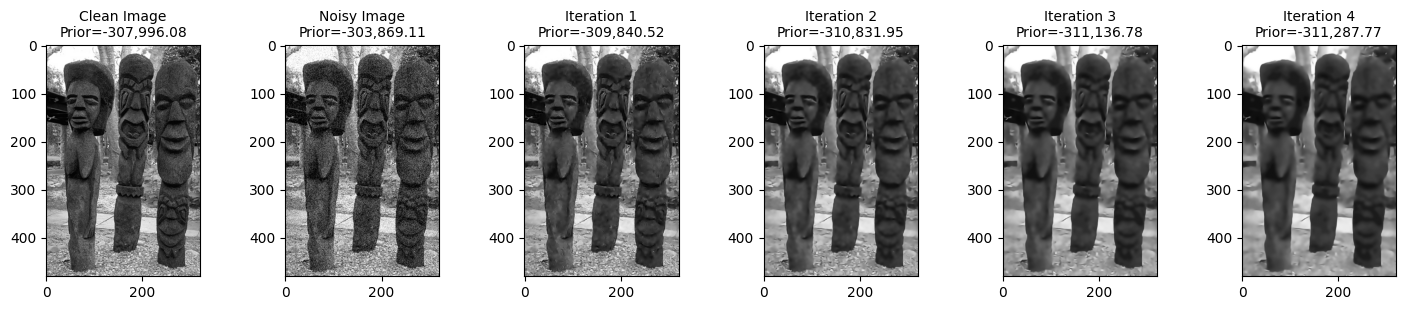

In [9]:
fig, axs = plt.subplots(1, rep + 2, figsize=((rep + 2) * 3, 3))

ax = axs[0]
ax.imshow(x[0, 0].cpu().detach(), cmap="gray", vmin=0, vmax=1)
ax.set_title(f"Clean Image\nPrior={prior_clean:,.2f}", fontsize=10)

ax = axs[1]
ax.imshow(noisy[0, 0].cpu().detach(), cmap="gray", vmin=0, vmax=1)
ax.set_title(f"Noisy Image\nPrior={prior_noisy:,.2f}", fontsize=10)


for i in range(rep):
    xhat = xhats[i]
    prior = priors[i]
    ax = axs[i + 2]
    ax.imshow(xhat[0, 0].cpu().detach(), cmap="gray", vmin=0, vmax=1)
    ax.set_title(f"Iteration {i+1}\nPrior={prior:,.2f}", fontsize=10)